In [1]:
import torch
import sys

import torch.nn as nn
import torch.optim as optim
import config
import numpy as np

import matplotlib.pyplot as plt
import torchvision.utils as vutils # 这两个是做可视化用的

from tqdm import tqdm #计时模块
from torchvision.utils import save_image
from utils import save_some_examples, save_checkpoint, load_checkpoint
from torch.utils.data import DataLoader

from dataset import RealVanDataset  # 数据集模块

from discriminator_model import Discriminator # 判别器模块
from generator_model import Generator # 生成器模块

### 1： 加载数据集

In [2]:
# 训练集加载
root_train_real = "data/train/real" 
root_train_van =  "data/train/van"

# 数据集加载
dataset = RealVanDataset(root_train_real,root_train_van,transform=config.transforms)

# 对数据集进行minibattch处理
loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS,pin_memory=True)

In [3]:
# 对训练集做可视化
real_batch = next(iter(loader))
print(real_batch[0].shape)

torch.Size([1, 3, 256, 256])


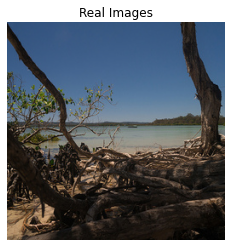

In [4]:
# 对于真实的图片做可视化，因为batch size为1 所以只有一张
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(config.DEVICE)[:16], nrow=1, padding=2, normalize=True).cpu(),(1,2,0)))

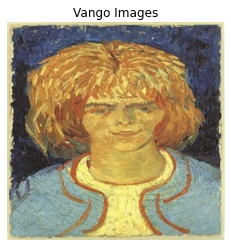

In [5]:
# 对于梵高画作的图片做可视化，因为batch size为1 所以只有一张
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Vango Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[1].to(config.DEVICE)[:16], nrow=1, padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# 验证集的加载
root_test_real = "data/val/real" 
root_test_van =  "data/val/van"
val_dataset = RealVanDataset(root_test_real,root_test_van,transform=config.transforms)

# 对验证集集进行minibattch处理
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,pin_memory=True)

### 2: 模型初始化

In [7]:
# 对GradScaler（）初始化一个对象 为了自动混合精度
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [8]:
# 生成器模型初始化 CycleGan中有两个生成器

# 从真实图片生成梵高画作的生成器
gen_van = Generator(img_channels=3, num_residuals=9).to(config.DEVICE)

# 从梵高画作生成真实图片的生成器
gen_real = Generator(img_channels=3, num_residuals=9).to(config.DEVICE)

In [9]:
# 判别器模型初始化 CycleGan中也有两个判别器

# 对从真实图片生成的梵高图像的判别器
dis_van = Discriminator(in_channels=3).to(config.DEVICE)

# 对从梵高图像生成真实图像的判别器
dis_real = Discriminator(in_channels=3).to(config.DEVICE)

In [10]:
# 优化器初始化

# 生成器的优化器初始化
opt_gen = optim.Adam(
    list(gen_real.parameters())+list(gen_van.parameters()),
    lr=config.LEARNING_RATE,
    betas=(0.5,0.999)
)

# 判别器的优化器初始化
opt_dis = optim.Adam(
    list(dis_van.parameters()) + list(dis_real.parameters()),
    lr=config.LEARNING_RATE,
    betas=(0.5, 0.999),
)

In [11]:
# 损失函数的初始化
L1 = nn.L1Loss()
mse = nn.MSELoss()

### 3: 模型训练

In [12]:
if config.LOAD_MODEL:
        load_checkpoint(
            config.CHECKPOINT_GEN_Van, gen_van, opt_gen, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_GEN_Real, gen_real, opt_gen, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_CRITIC_Van, dis_van, opt_dis, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_CRITIC_Real, dis_real, opt_dis, config.LEARNING_RATE,
        )

In [13]:
def train_fn(dis_van, dis_real, gen_van, gen_real, loader, opt_dis, opt_gen, l1, mse, d_scaler, g_scaler):
    
    Van_reals = 0
    Van_fakes = 0
    
    loop = tqdm(loader, leave=True)

    for idx, (real, van) in enumerate(loop):
        real = real.to(config.DEVICE)
        van = van.to(config.DEVICE)
        
        # 先训练判别器
        # 精度自适应，只用于前向传播
        with torch.cuda.amp.autocast():
            
            # 从真实图片到梵高的过程
            fake_van = gen_van(real)
            
            D_van_fake = dis_van(fake_van.detach()) # D（G（x))
            D_van_real = dis_van(van) # D(Y)
            
            D_van_fake_loss = mse(D_van_fake,torch.zeros_like(D_van_fake))
            D_van_real_loss = mse(D_van_real,torch.ones_like(D_van_real))
            
            D_van_loss = D_van_fake_loss+D_van_real_loss
            
            
            Van_reals += D_van_real.mean().item()  # D(Y) 这个值越大越好
            Van_fakes += D_van_fake.mean().item()  # D（G（x)) 这个值越小越好
            
            # 从梵高图片到真实的过程
            fake_real = gen_real(van)
            
            D_real_fake = dis_real(fake_real.detach())
            D_real_real = dis_real(real)
            
            D_real_fake_loss = mse(D_real_fake,torch.zeros_like(D_real_fake))
            D_real_real_loss = mse(D_real_real,torch.ones_like(D_real_real))
            
            D_real_loss = D_real_fake_loss+D_real_real_loss
            
            # 将两个求和 ，即希望这两个损失都答到最小
            D_loss = (D_van_loss+D_real_loss)/2
        
        opt_dis.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_dis)
        d_scaler.update()
        
        # 训练生成器,依然有两个生成器需要训练
        with torch.cuda.amp.autocast():
            
            # 首先是对抗生成网络的标准损失
            # 从真实图片到梵高
            D_van_fake = dis_van(fake_van)
            D_van_fake_loss_G = mse(D_van_fake,torch.ones_like(D_van_fake))
            
            # 从梵高到真实图片
            D_real_fake = dis_real(fake_real)
            D_real_fake_loss_G = mse(D_real_fake,torch.ones_like(D_real_fake))
            
            G_loss = D_van_fake_loss_G + D_real_fake_loss_G
            
            
            # 是两组domian从生成再还原以后的相似性的L1损失
            # 首先是 真实到梵高再到真实
            cycle_real = gen_real(fake_van)
            cycle_real_loss = l1(cycle_real,real)
            
            # 其次是 梵高到真实再到梵高
            cycle_van = gen_van(fake_real)
            cycle_van_loss = l1(cycle_van,van)
            
            G_loss = G_loss + (cycle_real_loss + cycle_van_loss)*config.LAMBDA_CYCLE
            
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update() 
        
        
        loop.set_postfix(Van_reals=Van_reals/(idx+1), Van_fakes=Van_fakes/(idx+1))

In [14]:
for epoch in range(config.NUM_EPOCHS):
        train_fn(dis_van, dis_real, gen_van, gen_real, loader, opt_dis, opt_gen, L1, mse, d_scaler, g_scaler)

        if config.SAVE_MODEL:
            save_checkpoint(gen_van, opt_gen, filename=config.CHECKPOINT_GEN_Van)
            save_checkpoint(gen_real, opt_gen, filename=config.CHECKPOINT_GEN_Real)
            save_checkpoint(dis_van, opt_dis, filename=config.CHECKPOINT_CRITIC_Van)
            save_checkpoint(dis_real, opt_dis, filename=config.CHECKPOINT_CRITIC_Real)
            
        save_some_examples(gen_van, val_loader, epoch, folder="evaluation")

100%|█████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.93it/s, Van_fakes=0.46, Van_reals=0.547]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:54<00:00,  5.74it/s, Van_fakes=0.442, Van_reals=0.567]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.92it/s, Van_fakes=0.442, Van_reals=0.567]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.89it/s, Van_fakes=0.444, Van_reals=0.563]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:56<00:00,  5.67it/s, Van_fakes=0.438, Van_reals=0.567]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:53<00:00,  5.75it/s, Van_fakes=0.438, Van_reals=0.568]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:56<00:00,  5.68it/s, Van_fakes=0.435, Van_reals=0.568]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.90it/s, Van_fakes=0.437, Van_reals=0.565]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.88it/s, Van_fakes=0.436, Van_reals=0.567]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.85it/s, Van_fakes=0.439, Van_reals=0.564]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:52<00:00,  5.80it/s, Van_fakes=0.437, Van_reals=0.565]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.91it/s, Van_fakes=0.435, Van_reals=0.566]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.93it/s, Van_fakes=0.437, Van_reals=0.565]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.85it/s, Van_fakes=0.438, Van_reals=0.566]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.85it/s, Van_fakes=0.438, Van_reals=0.564]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.84it/s, Van_fakes=0.435, Van_reals=0.566]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.92it/s, Van_fakes=0.435, Van_reals=0.567]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.95it/s, Van_fakes=0.432, Van_reals=0.57]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.95it/s, Van_fakes=0.433, Van_reals=0.568]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.94it/s, Van_fakes=0.431, Van_reals=0.569]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.95it/s, Van_fakes=0.428, Van_reals=0.574]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.95it/s, Van_fakes=0.426, Van_reals=0.575]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.95it/s, Van_fakes=0.43, Van_reals=0.573]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.89it/s, Van_fakes=0.432, Van_reals=0.57]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:56<00:00,  5.68it/s, Van_fakes=0.432, Van_reals=0.568]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.92it/s, Van_fakes=0.426, Van_reals=0.574]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.92it/s, Van_fakes=0.426, Van_reals=0.575]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.86it/s, Van_fakes=0.424, Van_reals=0.575]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.84it/s, Van_fakes=0.426, Van_reals=0.575]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.86it/s, Van_fakes=0.424, Van_reals=0.577]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.84it/s, Van_fakes=0.427, Van_reals=0.574]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.86it/s, Van_fakes=0.426, Van_reals=0.574]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.92it/s, Van_fakes=0.425, Van_reals=0.574]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.93it/s, Van_fakes=0.427, Van_reals=0.575]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.94it/s, Van_fakes=0.424, Van_reals=0.578]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.94it/s, Van_fakes=0.421, Van_reals=0.579]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:52<00:00,  5.79it/s, Van_fakes=0.424, Van_reals=0.576]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:56<00:00,  5.69it/s, Van_fakes=0.423, Van_reals=0.577]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.91it/s, Van_fakes=0.425, Van_reals=0.574]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.93it/s, Van_fakes=0.426, Van_reals=0.575]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.92it/s, Van_fakes=0.423, Van_reals=0.576]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.92it/s, Van_fakes=0.427, Van_reals=0.575]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.85it/s, Van_fakes=0.425, Van_reals=0.575]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.90it/s, Van_fakes=0.421, Van_reals=0.577]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.94it/s, Van_fakes=0.422, Van_reals=0.576]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.92it/s, Van_fakes=0.42, Van_reals=0.577]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.94it/s, Van_fakes=0.42, Van_reals=0.579]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.91it/s, Van_fakes=0.421, Van_reals=0.576]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.93it/s, Van_fakes=0.419, Van_reals=0.581]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:59<00:00,  5.59it/s, Van_fakes=0.42, Van_reals=0.577]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:53<00:00,  5.78it/s, Van_fakes=0.42, Van_reals=0.577]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [03:01<00:00,  5.51it/s, Van_fakes=0.42, Van_reals=0.578]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.94it/s, Van_fakes=0.42, Van_reals=0.579]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:47<00:00,  5.99it/s, Van_fakes=0.42, Van_reals=0.578]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.95it/s, Van_fakes=0.418, Van_reals=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.418, Van_reals=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.418, Van_reals=0.579]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.419, Van_reals=0.577]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.94it/s, Van_fakes=0.419, Van_reals=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:47<00:00,  5.98it/s, Van_fakes=0.417, Van_reals=0.581]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:47<00:00,  5.97it/s, Van_fakes=0.416, Van_reals=0.581]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:47<00:00,  5.98it/s, Van_fakes=0.416, Van_reals=0.582]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:47<00:00,  5.98it/s, Van_fakes=0.417, Van_reals=0.583]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.417, Van_reals=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.415, Van_reals=0.583]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.418, Van_reals=0.581]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.94it/s, Van_fakes=0.416, Van_reals=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.83it/s, Van_fakes=0.418, Van_reals=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.94it/s, Van_fakes=0.417, Van_reals=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.415, Van_reals=0.584]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.417, Van_reals=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.416, Van_reals=0.581]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.418, Van_reals=0.582]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.414, Van_reals=0.582]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.83it/s, Van_fakes=0.414, Van_reals=0.583]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:52<00:00,  5.79it/s, Van_fakes=0.414, Van_reals=0.583]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:53<00:00,  5.78it/s, Van_fakes=0.415, Van_reals=0.584]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:56<00:00,  5.66it/s, Van_fakes=0.412, Van_reals=0.585]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.94it/s, Van_fakes=0.415, Van_reals=0.584]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.95it/s, Van_fakes=0.412, Van_reals=0.584]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:47<00:00,  5.99it/s, Van_fakes=0.414, Van_reals=0.584]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:46<00:00,  6.00it/s, Van_fakes=0.412, Van_reals=0.584]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.95it/s, Van_fakes=0.412, Van_reals=0.586]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.88it/s, Van_fakes=0.411, Van_reals=0.586]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.91it/s, Van_fakes=0.413, Van_reals=0.586]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.96it/s, Van_fakes=0.41, Van_reals=0.588]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.88it/s, Van_fakes=0.41, Van_reals=0.588]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:47<00:00,  5.97it/s, Van_fakes=0.409, Van_reals=0.588]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.88it/s, Van_fakes=0.409, Van_reals=0.588]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.86it/s, Van_fakes=0.409, Van_reals=0.587]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.86it/s, Van_fakes=0.408, Van_reals=0.588]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.92it/s, Van_fakes=0.408, Van_reals=0.59]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.92it/s, Van_fakes=0.408, Van_reals=0.589]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:49<00:00,  5.92it/s, Van_fakes=0.41, Van_reals=0.587]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.93it/s, Van_fakes=0.408, Van_reals=0.589]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.93it/s, Van_fakes=0.408, Van_reals=0.591]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:48<00:00,  5.93it/s, Van_fakes=0.403, Van_reals=0.591]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|█████████████████████████████████████████████| 1001/1001 [02:50<00:00,  5.88it/s, Van_fakes=0.406, Van_reals=0.59]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.85it/s, Van_fakes=0.405, Van_reals=0.591]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|████████████████████████████████████████████| 1001/1001 [02:51<00:00,  5.85it/s, Van_fakes=0.405, Van_reals=0.592]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
